In [14]:
import fireworks
from fireworks.ic import ic_two_body as ic_two_body

from fireworks.nbodylib import dynamics as dyn
from fireworks.nbodylib import integrators as intg

import matplotlib.pyplot as plt
import numpy as np

In [15]:
def ininitialise(mass1=1, mass2=1, rp=1, e=0):
    particles = ic_two_body(mass1, mass2, rp, e)

    a = rp / (1 - e)  # Semi-major axis
    period = 2 * np.pi * np.sqrt(a**3 / (mass1 + mass2))

    return particles, period


In [16]:
mass1 = 15.0
mass2 = 2.0
rp = 2.0
e = 0.0

particles = ic_two_body(mass1, mass2, rp, e)

Estimate binary period.

From Kepler's law:

$$
T^2 = \frac{4 \pi^2}{G(M+m)}  a^3
$$

where $a$ is the semi-major axis, which is given from initial condition $rp = r_{min}$:

$$
a=\frac{r_{min}}{(1-e)}
$$

In [17]:
a = rp / (1 - e)  # Semi-major axis
period = 2 * np.pi * np.sqrt(a**3 / (mass1 + mass2))


Develop an interactive method to evolve the binary system from 0 to 10x Tperiod

In [18]:
def simulate(integrator,particles,tstep=0.01,total_time = 10):

  

   acc_list       = np.array([])
   pos_list       = np.array([])
   vel_list       = np.array([])
   kinetic_list   = np.array([])
   potential_list = np.array([])
   energy_list    = np.array([])
   
   
   for _ in range(int(total_time/tstep)):

      particles, tstep, acc, jerk, _ = integrator(particles=particles, 
                                               tstep=tstep, 
                                               acceleration_estimator=dyn.acceleration_direct_vectorized,
                                               softening=0.1,
                                               )
      
      acc_list = np.append(acc_list, acc)
      pos_list = np.append(pos_list, particles.pos)
      vel_list = np.append(vel_list, particles.vel)

      kinetic_list   = np.append(kinetic_list, particles.Ekin())
      potential_list = np.append(potential_list, particles.Epot(softening=0.1))
      energy_list    = np.append(energy_list, particles.Etot(softening=0.1))


   acc_list = acc_list.reshape(int(total_time/tstep), 2, 3)
   pos_list = pos_list.reshape(int(total_time/tstep), 2, 3)
   vel_list = vel_list.reshape(int(total_time/tstep), 2, 3)

   return acc_list, pos_list, vel_list, kinetic_list, potential_list, energy_list
      


In [19]:
def integration_loop(period):


   simulation_data = {}

   #for integrator in [intg.integrator_euler, intg.integrator_leapfrog,intg.integrator_hermite]:
   for integrator in [intg.integrator_hermite, intg.integrator_euler]:
      acc_list, pos_list, vel_list, kinetic_list, potential_list, energy_list = simulate(integrator,particles,tstep=.1,total_time = period)

      simulation_data[integrator.__name__] = {"acc_list": acc_list, "pos_list": pos_list, "vel_list": vel_list, "energy_list": energy_list}
      
   return simulation_data

In [20]:
#simulation_data = integration_loop()

def plot_sim(key: str, simulation_data: dict):

    # Get the list of integrators from the simulation_data dictionary
    integrators = list(simulation_data.keys())

    # Create a grid plot with subplots for each integrator
    fig, axs = plt.subplots(len(integrators), 1, figsize=(8, 6 * len(integrators)))

    # Iterate over each integrator and plot pos_list
    for i, integrator in enumerate(integrators):
        data = simulation_data[integrator][key]
        axs[i].plot(data[:, 0, 0], data[:, 0, 1], label="Star 1")
        axs[i].plot(data[:, 1, 0], data[:, 1, 1], label="Star 2")
        axs[i].set_title(integrator)
        axs[i].legend()





In [21]:
"""""
# grid search on rp 
rps = np.arange(.01, 10, .1)

for rp in rps:
     particles, period = ininitialise(mass1=15, mass2=1, rp=rp, e=0)
     simulation_data = integration_loop()
     plot_sim("pos_list", simulation_data)


     """   

'""\n# grid search on rp \nrps = np.arange(.01, 10, .1)\n\nfor rp in rps:\n     particles, period = ininitialise(mass1=15, mass2=1, rp=rp, e=0)\n     simulation_data = integration_loop()\n     plot_sim("pos_list", simulation_data)\n\n\n     '

In [22]:

"""""
rps = np.arange(.01, 10, .1)

for rp in rps:
STOP
    particles, period = ininitialise(mass1=1, mass2=1, rp=rp, e=0)

    simulation_data = integration_loop(10*period)
    plot_sim("pos_list", simulation_data)
"""

'""\nrps = np.arange(.01, 10, .1)\n\nfor rp in rps:\nSTOP\n    particles, period = ininitialise(mass1=1, mass2=1, rp=rp, e=0)\n\n    simulation_data = integration_loop(10*period)\n    plot_sim("pos_list", simulation_data)\n'

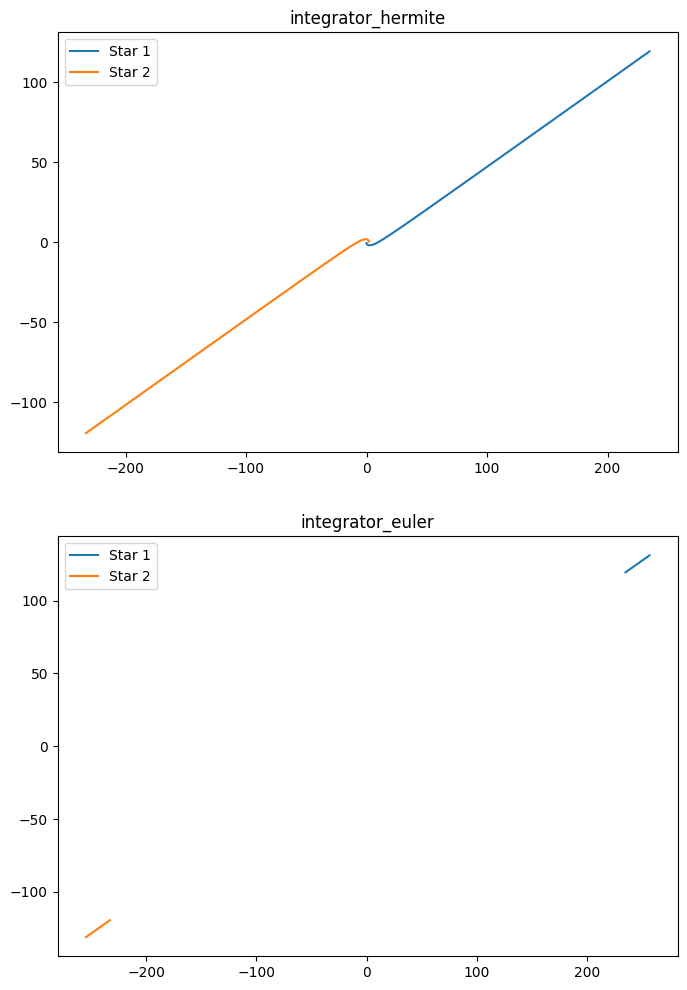

In [25]:
particles, period = ininitialise(mass1=1, mass2=1, rp=2, e=0)

simulation_data = integration_loop(10*period)
plot_sim("pos_list", simulation_data)
